# Software Defect Prediction Using Machine Learning
This notebook demonstrates how to build a machine learning model to predict software defects using the NASA CM1 dataset or similar.

In [ ]:
# Step 1: Install required packages
!pip install pandas scikit-learn matplotlib seaborn imbalanced-learn xgboost

In [1]:
# Step 2: Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib

In [22]:
# Step 3: Load Dataset (change filename as needed)
df = pd.read_csv("/cm1.csv")
print(df.head())
print(df.info())
print(df.isna().sum())


   McCabe's line count of code  McCabe "cyclomatic complexity”  \
0                          1.1                             1.4   
1                          1.0                             1.0   
2                         24.0                             5.0   
3                         20.0                             4.0   
4                         24.0                             6.0   

   McCabe "essential complexity”  McCabe "design complexity”  \
0                            1.4                         1.4   
1                            1.0                         1.0   
2                            1.0                         3.0   
3                            4.0                         2.0   
4                            6.0                         2.0   

   Halstead total operators + operands  Halstead "volume”  \
0                                  1.3               1.30   
1                                  1.0               1.00   
2                                 6

In [23]:
df_cleaned = df.dropna(subset=['defects'])


In [14]:
# Step 4: Data Preprocessing
df['defects'] = df['defects'].map({'Y': 1, 'N': 0})

# Remove low variance features
sel = VarianceThreshold(threshold=0.01)
X = df.drop('defects', axis=1)
X_selected = sel.fit_transform(X)
X_selected = pd.DataFrame(X_selected)

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
y = df['defects']

In [24]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

# Assume df_cleaned is the DataFrame after dropping NaNs in 'defects' (your code)
X = df_cleaned.drop('defects', axis=1)
y = df_cleaned['defects']

# Variance Threshold - Feature selection
sel = VarianceThreshold(threshold=0.01)
X_selected_np = sel.fit_transform(X)  # numpy array

# Get selected feature columns (boolean mask)
selected_features_mask = sel.get_support()

# Keep selected column names
selected_columns = X.columns[selected_features_mask]

# Re-create DataFrame with selected columns, keeping the original index
X_selected = pd.DataFrame(X_selected_np, columns=selected_columns, index=X.index)

# Now scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Important: Align y index with X_selected's index
y_aligned = y.loc[X_selected.index]

# Now do train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_aligned, test_size=0.3, stratify=y_aligned, random_state=42
)

# SMOTE oversampling
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [25]:
# Step 7: Train and Evaluate Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


Logistic Regression
[[102  33]
 [  7   8]]
              precision    recall  f1-score   support

       False       0.94      0.76      0.84       135
        True       0.20      0.53      0.29        15

    accuracy                           0.73       150
   macro avg       0.57      0.64      0.56       150
weighted avg       0.86      0.73      0.78       150


Random Forest
[[120  15]
 [ 10   5]]
              precision    recall  f1-score   support

       False       0.92      0.89      0.91       135
        True       0.25      0.33      0.29        15

    accuracy                           0.83       150
   macro avg       0.59      0.61      0.60       150
weighted avg       0.86      0.83      0.84       150



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:46:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost
[[117  18]
 [ 12   3]]
              precision    recall  f1-score   support

       False       0.91      0.87      0.89       135
        True       0.14      0.20      0.17        15

    accuracy                           0.80       150
   macro avg       0.52      0.53      0.53       150
weighted avg       0.83      0.80      0.81       150



In [26]:
# Step 8: Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10]
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='f1')
grid.fit(X_train_res, y_train_res)
print("Best Parameters:", grid.best_params_)

y_pred_best = grid.predict(X_test)
print(classification_report(y_test, y_pred_best))

Best Parameters: {'max_depth': 10, 'n_estimators': 50}
              precision    recall  f1-score   support

       False       0.91      0.83      0.87       135
        True       0.15      0.27      0.19        15

    accuracy                           0.77       150
   macro avg       0.53      0.55      0.53       150
weighted avg       0.83      0.77      0.80       150



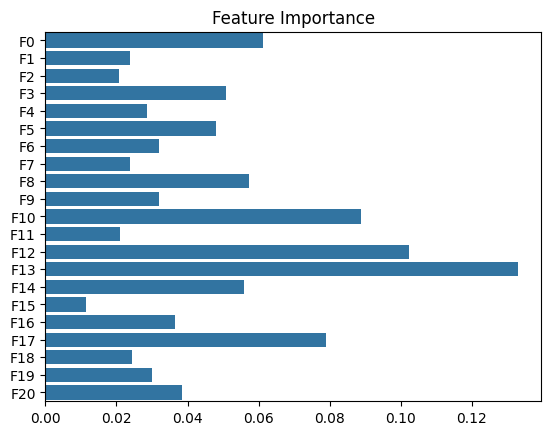

In [27]:
# Step 9: Feature Importance
importances = grid.best_estimator_.feature_importances_
sns.barplot(x=importances, y=[f"F{i}" for i in range(len(importances))])
plt.title("Feature Importance")
plt.show()

In [28]:
# Step 10: Save the Model
joblib.dump(grid.best_estimator_, 'defect_predictor.pkl')

['defect_predictor.pkl']

In [29]:
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [30]:
y_pred = model.predict(X_test)


In [31]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8
